# Gender Classifier using Deep CNNs  - 

**Dataset : UTKFace**

UTKFace dataset is a large-scale face dataset with long age span (range from **0 to 116 years old**). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc.

In this notebook, I have used the **aligned and cropped** faces available to train my models. Needless to say, any face input for testing must be cropped and aligned vertically to large extent.

#### Working Methodology - 

I initially tried all 3 fundamental convolutional layers - `Conv2D`, `SeperableConv2D` and `Conv2DTranspose`. I found `SeperableConv2D` to perform the best. Then I tried using some key arguments of it and noted down its results.
Finally, for the best among those, I tested the performance of my models on 4 of the most popular and promising optimizers Keras has - **Adam**, **Adamax**, **SGD**, **Nadam**.

In [ ]:
# Mounting the drive so that dataset can be loaded

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Essential libraries
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import applications,activations
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers,utils
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D, Input
from keras.layers import Conv2D, Activation,MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
dataset_folder_name = '/content/drive/My Drive/Images'
TRAIN_TEST_SPLIT = 0.8
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())    # (Gender: id)
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())        # (Race: id)

In [ ]:
# Let's also define a function to help us on extracting the data from our dataset. This function will be
# used to iterate over each file of the UTK dataset and return a Pandas Dataframe containing all the
# fields (age, gender and sex) of our records.

def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame
     with the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    
   
    df = df.dropna()
    
    return df

In [ ]:
# GENDER - 0 - MALE, 1 - FEMALE

df = parse_dataset(dataset_folder_name)
df.head()

# Now we have a pandas dataframe with us. This can be dealt with quite easily. Like, we simply now need 
# to OHE gender, race and feed it into model. Using Pandas dataframe also allows me to manipulate and 
# visualize data by plotting graphs.

,age,gender,race,file
0,17.0,male,others,/content/drive/My Drive/Images/17_0_4_20170103...
1,17.0,female,white,/content/drive/My Drive/Images/17_1_0_20170102...
2,17.0,male,others,/content/drive/My Drive/Images/17_0_4_20170102...
3,17.0,female,white,/content/drive/My Drive/Images/17_1_0_20170103...
4,17.0,male,others,/content/drive/My Drive/Images/17_0_4_20170103...


### Data analysis & visualization (EDA)

After some data preprocessing, let's analyze the data using graphs to get a  better understanding about its distribution





In [ ]:
df.info()       # No NAN values. Clean dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23708 entries, 0 to 23710
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     23708 non-null  float64
 1   gender  23708 non-null  object 
 2   race    23708 non-null  object 
 3   file    23708 non-null  object 
dtypes: float64(1), object(3)
memory usage: 926.1+ KB


In [ ]:
df.describe()
# Lower percentile - 25, median - 50, upper percentile - 75 (for numerical data)

,age
count,23708.000000
mean,33.300363
std,19.884509
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


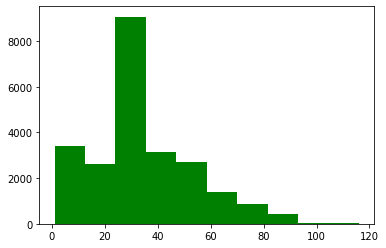

In [ ]:
ages = df['age']
nbins = 10
plt.hist(ages,nbins,color='green',histtype='bar')
plt.show()
# Majority population lies between 20-30 age group. Clearly, 
# the dataset is not very well balanced. So training will 
# not be easy & accurate. We don't want to be
# biased. Try using class weights

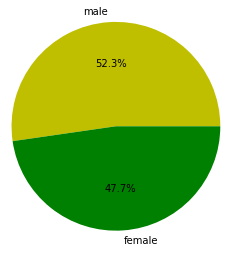

In [ ]:
x = (df.gender=='male').sum()
y = (df.gender=='female').sum()
gender = [x,y]
labels = ['male','female']
colors = [ 'y', 'g'] 
plt.pie(gender,labels = labels,colors = colors,radius=1.2,autopct='%.1f%%')
plt.show()
# Uniform distribution to a large extent. Although, males slightly exceed females 
# in numbers.No need to change gender in data. Pretty well balanced !
# Lets also visualize this on a bar graph (to get better understanding of numbers)

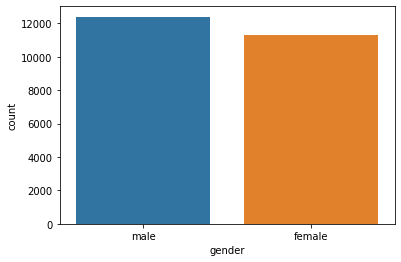

In [ ]:
sns.countplot(x='gender', data=df);

# Males ~ Just over 12k
# Females ~ Just over 11k

In [ ]:
df.groupby(['gender']).mean()             # Mean age by gender

,age
gender,
female,30.678186
male,35.694046


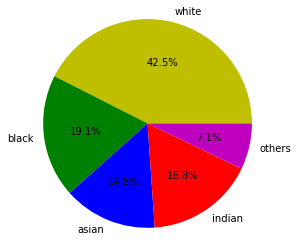

In [ ]:
x = (df.race=='white').sum()
y = (df.race=='black').sum()
z = (df.race=='asian').sum()
a = (df.race=='indian').sum()
b = (df.race=='others').sum()

gender = [x,y,z,a,b]
labels = ['white','black','asian','indian','others']
colors = [ 'y', 'g','b','r','m'] 
plt.pie(gender,labels = labels,colors = colors,radius=1.2,autopct='%.1f%%')
plt.show()

In [ ]:
df.groupby(['race']).mean()               # Mean age by race

,age
race,
asian,25.867501
black,33.860362
indian,31.532830
others,23.169031
white,37.978276


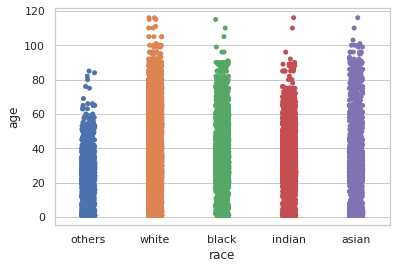

In [ ]:
sns.set(style ="whitegrid") 
_ = sns.stripplot(x='race',y='age',data=df)

# Not very useful :( , we only understand that not many elderly ppl (above 60) 
# in others category are present 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


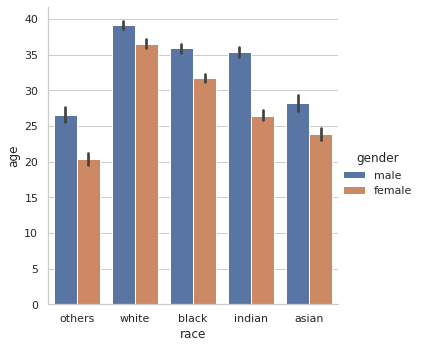

In [ ]:
sns.factorplot('race', 'age', 'gender', data=df,kind='bar');

# Gives the mean age of both genders of all races

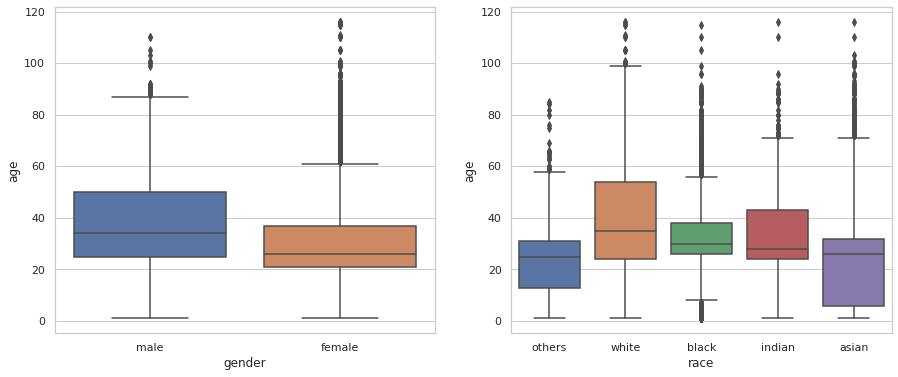

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

# We see that most of males are between 25 and 55, whereas most of the females are between 20 and 35
# Even while grouping by race, we find good amount of variations in different races

## Data Generator
In order to input our data to our Keras multi-output model, we have a helper object to work as a data generator for our dataset. This will be done by generating batches of data, which will be used to feed our multi-output model with both the images and their labels (instead of just loading all the dataset into the memory at once, which might lead to an out of memory error).

In [ ]:
p = np.random.permutation(len(df))

train_val_up_to = int(len(df) * 0.90)
train_val_idx = p[:train_val_up_to]

# Let's seperate test dataset

test_idx = p[train_val_up_to:]              # Last 10 % images after shuffling randomly

p = np.random.permutation(train_val_idx)              # Randomly permute these indices

# Splitting into train and test sets - 

train_up_to = int(len(train_val_idx) * 0.90)          # Roughly 81 % of whole dataset

train_idx = p[:train_up_to]
val_idx = p[train_up_to : ]

# Now we got train_idx, valid_idx, test_idx

In [ ]:
np.save('/content/drive/My Drive/train_idx.npy')
np.save('/content/drive/My Drive/test_idx.npy')
np.save('/content/drive/My Drive/val_idx.npy')

# Saving these indices of train, test and val set so these same images can be used
# in other 2 tasks - Age Estimation and Age Classification

In [ ]:
print(train_idx.size)
print(val_idx.size)
print(test_idx.size)

19203
2134
2371


In [ ]:
train_idx = np.load('/content/drive/My Drive/train_idx.npy') 
val_idx = np.load('/content/drive/My Drive/val_idx.npy') 
test_idx = np.load('/content/drive/My Drive/test_idx.npy') 

In [ ]:
y=[]
z=[]
a=[]
for i in range(len(train_idx)):
    x = train_idx[i]
    if df.loc[i,['gender']][0]=='male':
        y.append(0)
    else:
        y.append(1)

for i in range(len(val_idx)):
    x = val_idx[i]
    if df.loc[i,['gender']][0]=='male':
        z.append(0)
    else:
        z.append(1)

for i in range(len(test_idx)):
    x = test_idx[i]
    if df.loc[i,['gender']][0]=='male':
        a.append(0)
    else:
        a.append(1)

In [ ]:
# TRAIN
t1 = y.count(0)
t2 = y.count(1)
print(t1,' ',t2)

# VAL
t3 = z.count(0)
t4 = z.count(1)
print(t3,' ',t4)

#TEST
t5 = a.count(0)
t6 = a.count(1)
print(t5,' ',t6)

In [ ]:
print('Percentage of males in TRAINING SET: ', str(t1/(t1+t2)))
print('Percentage of males in VALIDATION SET: ', str(t3/(t3+t4)))
print('Percentage of males in TEST SET: ', str(t5/(t5+t6)))


Percentage of males in TRAINING SET:  0.5316356819246992
Percentage of males in VALIDATION SET:  0.5866916588566073
Percentage of males in TEST SET:  0.6060733867566428


Now, we can see in the pie chart during the EDA of the entire dataset that the percentage of males in the entire dataset was **52.3 %**. The fraction of males (and hence females) in the divided datasets  almost matches that of the original dataset. This means that the division is good.

**Note** - Only the distribution of `training` and `validation` set matters here (actually only training matters). We want a robust model with excellent generalization ability to function well on real life images. And in real life, it can encounter even 100 female images at a time (and no males) and it should be able to predict correctly. So, it is okay to have an unbalanced test set.

In [ ]:
from keras.utils import to_categorical
from PIL import Image

# converts alias to id
df['gender_id'] = df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
         
def preprocess_image(img_path):
    """
    Used to perform some minor preprocessing on the image before inputting into the network.
    """
    im = Image.open(img_path)
    im = im.resize((180, 180))
    im = np.array(im) / 255.0
    
    return im
        
def generate_images(image_idx, is_training, batch_size=16):
    """
    Used to generate a batch with images when training/testing/validating our Keras model.
    """
    
    # arrays to store our batched data
    images, genders = [], []
    while True:
        for idx in image_idx:
            person = df.iloc[idx]
            
            gender = person['gender_id']
            file = person['file']
            
            im = preprocess_image(file)

            genders.append(to_categorical(gender, 2))
            images.append(im)
            
            # yielding condition
            if len(images) >= batch_size:
                yield np.array(images), np.array(genders)
                images, genders = [], []
                
        if not is_training:
            break
            

## Model Architecture

This is the best model architecture I found for gender prediction. It was arrived at after trying many other models such as `Conv2D`, `Conv2DTranspose`. Even in `SeperableConv2D`, I tried it's including/not including it's different arguments such as *kernel_initializer*, *kernel_constraint*, etc.

**NOTE:** All results below, have been obtained once I verified that performance was not improving. I stopped training then, otherwise the model would overfit and lose its generalization ability.

In [ ]:
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import SpatialDropout2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.constraints import max_norm

input_shape = (180, 180, 3)
inputs = Input(shape=input_shape)

x = SeparableConv2D(64, (3, 3), padding="same",depthwise_initializer='he_uniform', pointwise_initializer='he_uniform',kernel_constraint=max_norm(2.))(inputs)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = SeparableConv2D(128, (3, 3), padding="same",depthwise_initializer='he_uniform', pointwise_initializer='he_uniform',kernel_constraint=max_norm(2.))(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = SeparableConv2D(128, (3, 3), padding="same",depthwise_initializer='he_uniform', pointwise_initializer='he_uniform',kernel_constraint=max_norm(2.))(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.15)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(256, (3, 3), padding="same",depthwise_initializer='he_uniform', pointwise_initializer='he_uniform',kernel_constraint=max_norm(2.))(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.15)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(256, (3, 3), padding="same",depthwise_initializer='he_uniform', pointwise_initializer='he_uniform',kernel_constraint=max_norm(2.))(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.15)(x)
x = BatchNormalization()(x)

x = Flatten()(x)

x = Dense(128 , kernel_initializer='he_uniform',kernel_constraint=max_norm(2.))(x)
x = Activation("relu")(x)
x = Dropout(0.30)(x)
x = BatchNormalization()(x)

x = Dense(64 , kernel_initializer='he_uniform',kernel_constraint=max_norm(2.))(x)
x = Activation("relu")(x)
x = Dropout(0.30)(x)
x = BatchNormalization()(x)

x = Dense(32, kernel_initializer='he_uniform',kernel_constraint=max_norm(2.))(x)
x = Activation("relu")(x)
x = Dropout(0.20)(x)
x = BatchNormalization()(x)

x = Dense(2, kernel_initializer='he_uniform',kernel_constraint=max_norm(2.))(x)
x = Activation("softmax")(x)           

gender_model = Model(inputs=inputs, outputs=x)

In [ ]:
gender_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 180, 180, 3)       0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 180, 180, 64)      283       
_________________________________________________________________
activation_1 (Activation)    (None, 180, 180, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 90, 64)        256       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 90, 90, 128)       8896      
_________________________________________________________________
activation_2 (Activation)    (None, 90, 90, 128)       0   

## ADAM Optimizer

### Model training - 

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.007
	drop = 0.7
	epochs_drop = 12.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adam(lr=0.0)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

gender_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = gender_model.fit(train_gen, steps_per_epoch = len(train_idx)//32, epochs=50  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/50
 93/600 [===>..........................] - ETA: 2:27:01 - loss: 0.7289 - accuracy: 0.5800

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


600/600 [==============================] - 12414s 21s/step - loss: 0.5529 - accuracy: 0.7177 - val_loss: 0.6434 - val_accuracy: 0.8040
Epoch 2/50
600/600 [==============================] - 157s 262ms/step - loss: 0.3996 - accuracy: 0.8193 - val_loss: 0.6560 - val_accuracy: 0.7481
Epoch 3/50
600/600 [==============================] - 158s 263ms/step - loss: 0.3615 - accuracy: 0.8381 - val_loss: 0.2434 - val_accuracy: 0.8603
Epoch 4/50
600/600 [==============================] - 157s 262ms/step - loss: 0.3524 - accuracy: 0.8421 - val_loss: 0.4199 - val_accuracy: 0.8518
Epoch 5/50
600/600 [==============================] - 158s 263ms/step - loss: 0.3345 - accuracy: 0.8517 - val_loss: 0.3024 - val_accuracy: 0.8651
Epoch 6/50
600/600 [==============================] - 156s 261ms/step - loss: 0.3220 - accuracy: 0.8606 - val_loss: 0.3188 - val_accuracy: 0.8584
Epoch 7/50
600/600 [==============================] - 157s 261ms/step - loss: 0.3397 - accuracy: 0.8478 - val_loss: 0.1694 - val_accura

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=950,
                  title='Train vs Val Loss',
                  xaxis_title='Epoch',
                  yaxis_title='loss')


fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=950,
                  title='Train vs Val Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')


fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
np.save('/content/drive/My Drive/GC_history.npy',history.history)

''' LOAD AS - 

 history1=np.load('/content/drive/My Drive/GC_history.npy',allow_pickle='TRUE').item()

 Use history1 everywhere instead of history.history  '''

In [ ]:
gender_model.save('/content/drive/My Drive/Colab Notebooks/GC_ADAM')
gender_model.save('/content/drive/My Drive/Colab Notebooks/GC_ADAM.h5')

# Saving the above run model.

###  Model testing - 

In [ ]:
test_idx                      # These are the indices that test set has

array([12772,  2874, 18889, ..., 11347, 23700,  1670])

In [ ]:
print(train_idx.size)         # ~~ 81 %
print(val_idx.size)           # ~~ 9 %
print(test_idx.size)          # ~~ 10 %

19203
2134
2371


In [ ]:
# Remember,  0 - MALE  &  1 - FEMALE

print(test_idx)             # Indices present in the test set
a = []
for i in test_idx:
    x = df.iloc[i]['gender']
    if x=='male':
       a.append(0)
    
    else:
       a.append(1)

print(a)

[12772  2874 18889 ... 11347 23700  1670]
[1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 

In [ ]:
test_generator = generate_images(test_idx, is_training=False, batch_size=1)
results = gender_model.predict_generator(test_generator, steps = 2371)

print(results.size)       # it gets multiplied by 2 here for there are 2 entries per entry of the list results
print('')
print(results)            # The predicted ages for the test set

# So here, batch_size=1 denotes that each time the function is called, a single image is evaluated upon
# step_size=2371 denotes the total number of steps (batches of samples) to yield from generator before stopping.
# We want all samples to be evaluated upon hence its 2371. Any more than that and a error pops up.

4742

[[3.7054470e-01 6.2945527e-01]
 [9.9975389e-01 2.4616433e-04]
 [9.1483742e-02 9.0851629e-01]
 ...
 [6.2755025e-03 9.9372452e-01]
 [5.6697667e-01 4.3302336e-01]
 [2.4774194e-02 9.7522587e-01]]


In [ ]:
b = []
for i in results:
    max=-1
    for j in range(2):
        if i[j]>max:
            max = i[j]
            temp = j
    b.append(temp)
print(b)

[1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 

In [ ]:
print(len(b),' ',len(a))

# a - Actual age class in the dataset
# b - Predicted class by my model

''' PREDICTED CLASS - 
0 - MALE
1 - FEMALE  '''

2371   2371


In [ ]:
count=0
for i in range(len(a)):
    if a[i]==b[i]:
        count+=1

acc = count/2371
print('Accuracy on test set is ', str(acc))

Accuracy on test set is  0.9451708140025306


## ADAMAX Optimizer

### Model training - 

In [ ]:
from keras.optimizers import Adamax
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.004
	drop = 0.6
	epochs_drop = 9.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adamax(lr=0.0)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

gender_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = gender_model.fit_generator(train_gen, steps_per_epoch = len(train_idx)//32, epochs=35  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/35
600/600 [==============================] - 136s 226ms/step - loss: 0.5524 - accuracy: 0.7199 - val_loss: 0.4866 - val_accuracy: 0.8329
Epoch 2/35
600/600 [==============================] - 134s 223ms/step - loss: 0.3678 - accuracy: 0.8364 - val_loss: 0.3548 - val_accuracy: 0.8670
Epoch 3/35
600/600 [==============================] - 134s 223ms/step - loss: 0.3189 - accuracy: 0.8580 - val_loss: 0.2354 - val_accuracy: 0.8802
Epoch 4/35
600/600 [==============================] - 133s 221ms/step - loss: 0.2920 - accuracy: 0.8701 - val_loss: 0.1455 - val_accuracy: 0.8935
Epoch 5/35
600/600 [==============================] - 133s 222ms/step - loss: 0.2669 - accuracy: 0.8829 - val_loss: 0.3898 - val_accuracy: 0.8949
Epoch 6/35
600/600 [==============================] - 133s 221ms/step - loss: 0.2535 - accuracy: 0.8917 - val_loss: 0.3487 - val_accuracy: 0.8977
Epoch 7/35
600/600 [==============================] - 132s 220ms/step - loss: 0.2336 - accuracy: 0.8989 - val_loss: 0.1148 -

In [ ]:

import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')


fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
gender_model.save('/content/drive/My Drive/Colab Notebooks/GC-ADAMAX')
gender_model.save('/content/drive/My Drive/Colab Notebooks/GC-ADAMAX.h5')

# Saving the above run model. 

### Model testing - 

In [ ]:
# Remember,  0 - MALE  &  1 - FEMALE

print(test_idx)             # Indices present in the test set
a = []
for i in test_idx:
    x = df.iloc[i]['gender']
    if x=='male':
       a.append(0)
    
    else:
       a.append(1)

print(a)

[12772  2874 18889 ... 11347 23700  1670]
[1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 

In [ ]:
test_generator = generate_images(test_idx, is_training=False, batch_size=1)
results = gender_model.predict_generator(test_generator, steps = 2371)

print(results)            # The predicted ages for the test set

# So here, batch_size=1 denotes that each time the function is called, a single image is evaluated upon
# step_size=2371 denotes the total number of steps (batches of samples) to yield from generator before stopping.
# We want all samples to be evaluated upon hence its 2371. Any more than that and a error pops up.

[[8.3456775e-03 9.9165428e-01]
 [9.9942756e-01 5.7241664e-04]
 [2.9278714e-03 9.9707210e-01]
 ...
 [4.7629474e-05 9.9995232e-01]
 [1.4501618e-02 9.8549843e-01]
 [8.8007422e-03 9.9119931e-01]]


In [ ]:
b = []
for i in results:
    max=-1
    for j in range(2):
        if i[j]>max:
            max = i[j]
            temp = j
    b.append(temp)
print(b)

[1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 

In [ ]:
count=0
for i in range(len(a)):
    if a[i]==b[i]:
        count+=1

acc = count/2371
print('Accuracy on test set is ', str(acc))

Accuracy on test set is  0.9135385913116828


## SGD Optimizer

### Model training - 

In [ ]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.007
	drop = 0.7
	epochs_drop = 12.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = SGD(lr=0.0)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

gender_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = gender_model.fit(train_gen, steps_per_epoch = len(train_idx)//32, epochs=45  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/45
600/600 [==============================] - 140s 233ms/step - loss: 0.6066 - accuracy: 0.6717 - val_loss: 0.5658 - val_accuracy: 0.7775
Epoch 2/45
600/600 [==============================] - 136s 226ms/step - loss: 0.5022 - accuracy: 0.7616 - val_loss: 0.3774 - val_accuracy: 0.8063
Epoch 3/45
600/600 [==============================] - 135s 226ms/step - loss: 0.4411 - accuracy: 0.7984 - val_loss: 0.2663 - val_accuracy: 0.8423
Epoch 4/45
600/600 [==============================] - 137s 228ms/step - loss: 0.4055 - accuracy: 0.8187 - val_loss: 0.2616 - val_accuracy: 0.8461
Epoch 5/45
600/600 [==============================] - 137s 229ms/step - loss: 0.3745 - accuracy: 0.8307 - val_loss: 0.4393 - val_accuracy: 0.8499
Epoch 6/45
600/600 [==============================] - 136s 227ms/step - loss: 0.3627 - accuracy: 0.8401 - val_loss: 0.3519 - val_accuracy: 0.8594
Epoch 7/45
600/600 [==============================] - 135s 226ms/step - loss: 0.3453 - accuracy: 0.8481 - val_loss: 0.1620 -

In [ ]:

import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')


fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
gender_model.save('/content/drive/My Drive/Colab Notebooks/GC-SGD')
gender_model.save('/content/drive/My Drive/Colab Notebooks/GC-SGD.h5')

# Saving the above run model. 

### Model testing - 

In [ ]:
# Remember,  0 - MALE  &  1 - FEMALE

print(test_idx)             # Indices present in the test set
a = []
for i in test_idx:
    x = df.iloc[i]['gender']
    if x=='male':
       a.append(0)
    
    else:
       a.append(1)

print(a)

[12772  2874 18889 ... 11347 23700  1670]
[1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 

In [ ]:
test_generator = generate_images(test_idx, is_training=False, batch_size=1)
results = gender_model.predict_generator(test_generator, steps = 2371)

print(results)            # The predicted ages for the test set

# So here, batch_size=1 denotes that each time the function is called, a single image is evaluated upon
# step_size=2371 denotes the total number of steps (batches of samples) to yield from generator before stopping.
# We want all samples to be evaluated upon hence its 2371. Any more than that and a error pops up.

[[1.7185139e-02 9.8281485e-01]
 [9.9983513e-01 1.6486632e-04]
 [1.1723753e-01 8.8276255e-01]
 ...
 [2.7253585e-02 9.7274643e-01]
 [5.2731276e-01 4.7268730e-01]
 [9.0973787e-03 9.9090260e-01]]


In [ ]:
b = []
for i in results:
    max=-1
    for j in range(2):
        if i[j]>max:
            max = i[j]
            temp = j
    b.append(temp)
print(b)

[1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 

In [ ]:
count=0
for i in range(len(a)):
    if a[i]==b[i]:
        count+=1

acc = count/2371
print('Accuracy on test set is ', str(acc))

Accuracy on test set is  0.8987768873892872


## SGD Optimizer with Momentum

### Model training - 

In [ ]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.004
	drop = 0.6
	epochs_drop = 10.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = SGD(lr=0.0, momentum=0.9)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

gender_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = gender_model.fit(train_gen, steps_per_epoch = len(train_idx)//32, epochs=45  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/45
 63/600 [==>...........................] - ETA: 2:54:51 - loss: 0.8070 - accuracy: 0.5337

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


600/600 [==============================] - 13059s 22s/step - loss: 0.6334 - accuracy: 0.6505 - val_loss: 0.6294 - val_accuracy: 0.7348
Epoch 2/45
600/600 [==============================] - 193s 322ms/step - loss: 0.5110 - accuracy: 0.7504 - val_loss: 0.4587 - val_accuracy: 0.7633
Epoch 3/45
600/600 [==============================] - 193s 322ms/step - loss: 0.4505 - accuracy: 0.7882 - val_loss: 0.3891 - val_accuracy: 0.8097
Epoch 4/45
600/600 [==============================] - 193s 322ms/step - loss: 0.3950 - accuracy: 0.8229 - val_loss: 0.2875 - val_accuracy: 0.8409
Epoch 5/45
600/600 [==============================] - 193s 322ms/step - loss: 0.3622 - accuracy: 0.8395 - val_loss: 0.4955 - val_accuracy: 0.8395
Epoch 6/45
600/600 [==============================] - 193s 321ms/step - loss: 0.3342 - accuracy: 0.8489 - val_loss: 0.3263 - val_accuracy: 0.8745
Epoch 7/45
600/600 [==============================] - 193s 321ms/step - loss: 0.3222 - accuracy: 0.8595 - val_loss: 0.1119 - val_accura

In [ ]:

import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')


fig.show()

<Figure size 432x288 with 0 Axes>

It's pretty clear from this graph that we got the noisiest training so far perhaps by using SGD with Momentum.

In [ ]:

import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')


fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
gender_model.save('/content/drive/My Drive/Colab Notebooks/GC-SGD_with_M')
gender_model.save('/content/drive/My Drive/Colab Notebooks/GC-SGD_with_M.h5')

# Saving the above run model. 

### Model testing - 

In [ ]:
# Remember,  0 - MALE  &  1 - FEMALE

print(test_idx)             # Indices present in the test set
a = []
for i in test_idx:
    x = df.iloc[i]['gender']
    if x=='male':
       a.append(0)
    
    else:
       a.append(1)

print(a)

[12772  2874 18889 ... 11347 23700  1670]
[1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 

In [ ]:
test_generator = generate_images(test_idx, is_training=False, batch_size=1)
results = gender_model.predict_generator(test_generator, steps = 2371)

print(results)            # The predicted ages for the test set

# So here, batch_size=1 denotes that each time the function is called, a single image is evaluated upon
# step_size=2371 denotes the total number of steps (batches of samples) to yield from generator before stopping.
# We want all samples to be evaluated upon hence its 2371. Any more than that and a error pops up.

[[1.6101243e-02 9.8389882e-01]
 [9.9907184e-01 9.2815491e-04]
 [1.6944053e-02 9.8305595e-01]
 ...
 [1.4989310e-02 9.8501068e-01]
 [5.7504076e-01 4.2495927e-01]
 [7.5012175e-03 9.9249882e-01]]


In [ ]:
b = []
for i in results:
    max=-1
    for j in range(2):
        if i[j]>max:
            max = i[j]
            temp = j
    b.append(temp)
print(b)

[1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 

In [ ]:
count=0
for i in range(len(a)):
    if a[i]==b[i]:
        count+=1

acc = count/2371
print('Accuracy on test set is ', str(acc))

Accuracy on test set is  0.8962463095740194


## NADAM Optimizer

### Model training - 

In [ ]:
from keras.optimizers import Nadam
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
	initial_lrate = 0.007
	drop = 0.7
	epochs_drop = 12.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Nadam(lr=0.0)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

gender_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = gender_model.fit(train_gen, steps_per_epoch = len(train_idx)//32, epochs=45  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/45
600/600 [==============================] - 134s 224ms/step - loss: 0.5164 - accuracy: 0.7455 - val_loss: 0.6081 - val_accuracy: 0.8381
Epoch 2/45
600/600 [==============================] - 133s 221ms/step - loss: 0.3602 - accuracy: 0.8381 - val_loss: 0.4212 - val_accuracy: 0.8153
Epoch 3/45
600/600 [==============================] - 132s 220ms/step - loss: 0.3329 - accuracy: 0.8522 - val_loss: 0.4352 - val_accuracy: 0.8423
Epoch 4/45
600/600 [==============================] - 133s 221ms/step - loss: 0.3187 - accuracy: 0.8613 - val_loss: 0.4523 - val_accuracy: 0.8153
Epoch 5/45
600/600 [==============================] - 135s 225ms/step - loss: 0.3186 - accuracy: 0.8573 - val_loss: 0.3371 - val_accuracy: 0.8617
Epoch 6/45
600/600 [==============================] - 134s 223ms/step - loss: 0.3486 - accuracy: 0.8446 - val_loss: 0.3612 - val_accuracy: 0.8641
Epoch 7/45
600/600 [==============================] - 134s 223ms/step - loss: 0.3453 - accuracy: 0.8481 - val_loss: 0.2754 -

In [ ]:
gender_model.save('/content/drive/My Drive/Colab Notebooks/GC_NADAM')
gender_model.save('/content/drive/My Drive/Colab Notebooks/GC_NADAM.h5')

# Saving the above run model. It has performed best till date.

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')


fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')


fig.show()

<Figure size 432x288 with 0 Axes>

### Model testing - 

In [ ]:
# Remember,  0 - MALE  &  1 - FEMALE

print(test_idx)             # Indices present in the test set
a = []
for i in test_idx:
    x = df.iloc[i]['gender']
    if x=='male':
       a.append(0)
    
    else:
       a.append(1)

print(a)

[12772  2874 18889 ... 11347 23700  1670]
[1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 

In [ ]:
test_generator = generate_images(test_idx, is_training=False, batch_size=1)
results = gender_model.predict_generator(test_generator, steps = 2371)

print(results)            # The predicted ages for the test set

# So here, batch_size=1 denotes that each time the function is called, a single image is evaluated upon
# step_size=2371 denotes the total number of steps (batches of samples) to yield from generator before stopping.
# We want all samples to be evaluated upon hence its 2371. Any more than that and a error pops up.

[[0.03504326 0.9649567 ]
 [0.9933908  0.00660924]
 [0.01967512 0.9803249 ]
 ...
 [0.00823276 0.9917672 ]
 [0.05930296 0.940697  ]
 [0.02249876 0.9775013 ]]


In [ ]:
b = []
for i in results:
    max=-1
    for j in range(2):
        if i[j]>max:
            max = i[j]
            temp = j
    b.append(temp)
print(b)

[1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 

In [ ]:
count=0
for i in range(len(a)):
    if a[i]==b[i]:
        count+=1

acc = count/2371
print('Accuracy on test set is ', str(acc))

Accuracy on test set is  0.897089835512442


The best model (**Adam** ) is able to predict classes with accuracy of **94.517 %** (which is awesome) on the test set. Don't forget that although the test set is from the same dataset (and hence the same distribution), model has not seen a single image from it.

**This tells us that the model has the ability to generalize well to unseen images (provided they are from right distribution)**

## Testing on some external images (using best model of the above) .
Have a look at some correctly classified images !

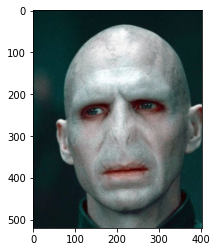

Male


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "/content/drive/My Drive/Some testing photos/vol.jpg"                                     
gender_pred = gender_model.predict(loadImage(picture))
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()

if gender_pred[0][0]>gender_pred[0][1]:
  print('Male')
else:
  print('Female')

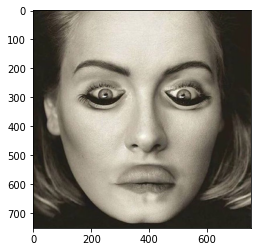

Female


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "/content/drive/My Drive/Some testing photos/in.jpg"                                     
gender_pred = gender_model.predict(loadImage(picture))
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()

if gender_pred[0][0]>gender_pred[0][1]:
  print('Male')
else:
  print('Female')

A misclassified image !

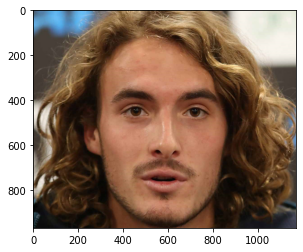

Female


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "/content/drive/My Drive/Some testing photos/tsit.jpg"                                     
gender_pred = gender_model.predict(loadImage(picture))
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()

if gender_pred[0][0]>gender_pred[0][1]:
  print('Male')
else:
  print('Female')